In [1]:
from pennystockpipeline.PennyStockData import PennyStockData
import numpy as np
import pandas as pd
from time import gmtime, strftime
from datetime import datetime, timedelta

## Initializing
DATABASE_NAME_WITH_PATH = "mod_historicaldata.db"
TABLE_NAME = "all_historical_modified"

#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
COLUMNS = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
COLUMNS_TO_NORMALIZE = ['volume_weighted_average']

SEQUENCE_LENGTH = 20
PREDICTION_LENGTH = 20

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockData(DATABASE_NAME_WITH_PATH, TABLE_NAME, impute=True, verbose=2)


[DEBUG][PennyStockData]: Imputed len(data): 965607
2024-06-01


In [2]:
psd = psd.get_columns(COLUMNS).normalize(COLUMNS_TO_NORMALIZE).create_sequences(SEQUENCE_LENGTH, PREDICTION_LENGTH)


[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MixMaxScaler


In [3]:
import torch # Library for implementing Deep Neural Network 
from pennystockpipeline.PennyStockModeler import PennyStockModeler

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 64
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)

# Define the model, loss function, and optimizer
modeler = PennyStockModeler(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, device='cuda')
modeler = modeler.to(modeler.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(modeler.parameters(), lr=1e-3)
print(modeler)



PennyStockModeler(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8
# Split data into train and test sets and create dataloaders
modeler = modeler.split_dataset(psd, split=TRAIN_TEST_SPLIT, to_torch=True).create_dataloaders(BATCH_SIZE)


x_train.shape: (32408, 20, 1), y_train.shape: (32408, 20, 1)
x_test.shape: (8102, 20, 1), y_test.shape: (8102, 20, 1)


Epoch [10/10] - Training Loss: 0.0003, Test Loss: 0.0002


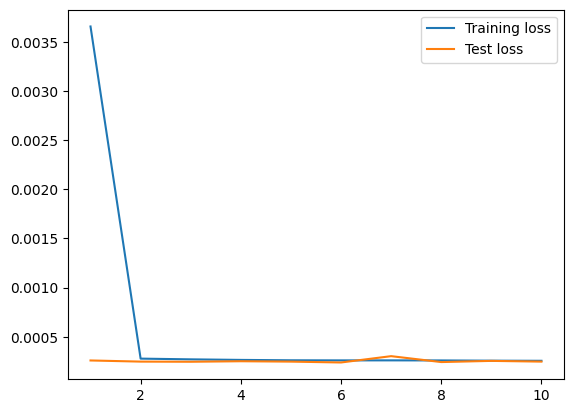

In [5]:
NUM_EPOCHS = 10
# Train the model
modeler = modeler.train_model(loss_fn, optimizer, num_epochs = NUM_EPOCHS).plot_training_test_loss()


In [11]:

def forecast(modeler, num_forecast_steps):
    # Define the number of future time steps to forecast
    modeler.num_forecast_steps = num_forecast_steps
     
    # Convert to NumPy and remove singleton dimensions
    sequence_to_plot = modeler.x_test.squeeze().cpu().numpy()

    # Use the last 36 data points as the starting point
    historical_data = sequence_to_plot[-1]
    
    # Initialize a list to store the forecasted values
    forecasted_values = []
     
    # Use the trained model to forecast future values
    with torch.no_grad():
        for _ in range(num_forecast_steps * 2):
            # Prepare the historical_data tensor
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(modeler.device)
            # Use the model to predict the next value
            predicted_value = modeler(historical_data_tensor).cpu().numpy()[0, 0]
            
            # Append the predicted value to the forecasted_values list
            forecasted_values.append(predicted_value[0])
     
            # Update the historical_data sequence by removing the oldest value and adding the predicted value
            #historical_data
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value

    # Generate
    modeler_psd_data_df = pd.DataFrame(modeler.psd.data, columns=modeler.psd.headers)
    psd_ds_dates = modeler_psd_data_df['p_date'].values.tolist()
    psd_ds_times = modeler_psd_data_df['p_time'].values.tolist()

    #psd_ds_dates_dt = [datetime.strptime(d, "%Y-%m-%d") for d in psd_ds_dates]
    #last_date = max(psd_ds_dates_dt)
    #next_date = last_date + timedelta(days=1)

    next_date = modeler.psd.next_max_date

    next_date_ls = [next_date for i in range(num_forecast_steps*3)]

    print(type(psd_ds_dates), type(psd_ds_dates[0]))
    print(type(next_date_ls), type(next_date_ls[0]))

    psd_ds_dates = psd_ds_dates + next_date_ls

    print(type(psd_ds_dates), type(psd_ds_dates[0]))
    print(type(next_date_ls), type(next_date_ls[0]))
    
    time_steps_set = psd_ds_times[:num_forecast_steps]
    psd_ds_times = psd_ds_times + psd_ds_times[:num_forecast_steps*3]

    #print(type(psd_ds_dates[0]), psd_ds_dates[0])
    
    # Concatenate the original index with the future dates
    modeler.psd_ds_dates = psd_ds_dates
    modeler.psd_ds_times = psd_ds_times

    modeler.forecasted_values = forecasted_values
    modeler.sequence_to_plot = sequence_to_plot

    return modeler

    





In [12]:
FORECAST_STEPS = 20

#modeler = modeler.forecast(num_forecast_steps = 30)
modeler = forecast(modeler, num_forecast_steps = FORECAST_STEPS)

C:\Users\moham\AppData\Local\Temp\ipykernel_14888\356604823.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


<class 'list'> <class 'str'>
<class 'list'> <class 'str'>
<class 'list'> <class 'str'>
<class 'list'> <class 'str'>


In [78]:
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler

def plot_forecasting(modeler):

    forecasted_values = modeler.forecasted_values
    
    psd_ds_dates = modeler.psd_ds_dates[-100:]
    psd_ds_times = modeler.psd_ds_times[-100:]

    # last 100 rows
    psd_ds_datetimes = []
    
    [psd_ds_datetimes.append(d + " " + t) for d,t in zip(psd_ds_dates, psd_ds_times)]

    test_data_x = modeler.x_test.squeeze().reshape(-1, 1).squeeze()
    #print(len(test_data_x))
    #print(type(test_data_x), test_data_x.shape)
    
    sequence_to_plot = modeler.sequence_to_plot
    
    modeler_psd_data_df = pd.DataFrame(modeler.psd.data, columns=modeler.psd.headers)
    
    #set the size of the plot 
    plt.rcParams['figure.figsize'] = [14, 4] 
    
    #Test data
    plt.plot(psd_ds_datetimes[-100:-40], test_data_x[-100:-40], label = "test_data", color = "b") 
    #reverse the scaling transformation
    original_cases = modeler.psd.scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0))#.flatten() 
    original_cases = original_cases.reshape(-1, 1).squeeze()
    
    #the historical data used as input for forecasting
    plt.plot(psd_ds_datetimes[-40:-20], original_cases, label='actual values', color='green') 
    
    #Forecasted Values 
    #reverse the scaling transformation
    forecasted_cases = modeler.psd.scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
    # plotting the forecasted values
    plt.plot(psd_ds_datetimes[-40:], forecasted_cases, label='forecasted values', color='red') 
    
    plt.xlabel('Time Step')
    plt.ylabel('Value')

    plt.xticks(psd_ds_datetimes, psd_ds_datetimes, rotation='vertical')
    plt.locator_params(axis='x', nbins=len(psd_ds_datetimes)/5)
    plt.tight_layout(pad=4)
    plt.subplots_adjust(bottom=0.15)

    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)



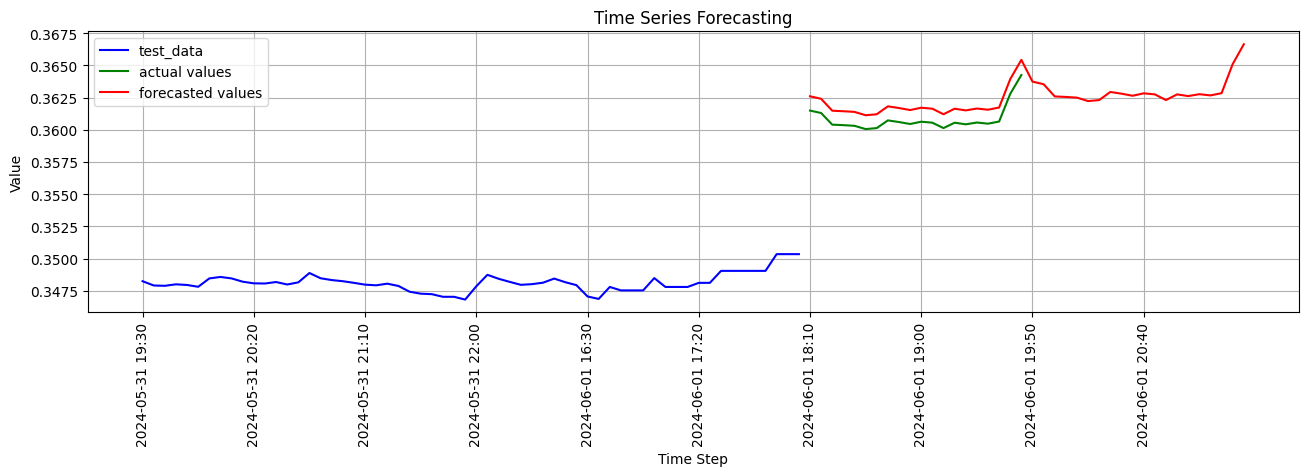

In [79]:
plot_forecasting(modeler)#, i_sequence_to_plot, i_forecasted_values, i_combined_index)

In [10]:
'''

#modeler.psd.ds_times.append(future_times)


# Generate the next 36 5-min intervals
#future_dates = pd.date_range(start=pd.to_datetime(next_date, format='%Y-%m-%d'), end=pd.to_datetime(next_date, format='%Y-%m-%d'), periods=num_forecast_steps) # we would get 30 forecasted values in 5 mins interval
#future_times = pd.interval_range(start=pd.to_datetime(start_time, format='%H:%M'), periods=num_forecast_steps, freq='5ME') # we would get 30 forecasted values in 5 mins interval

#df_ds_dates = pd.DataFrame(modeler.psd.ds_dates, columns=['p_date'])
#combined_dates_index = df_ds_dates.index.append(future_dates)

#df_ds_times = pd.DataFrame(modeler.psd.ds_times, columns=['p_time'])
#combined_times_index = df_ds_times.index.append(future_times)

return


# Define the number of future time steps to forecast
modeler.num_forecast_steps = num_forecast_steps
 
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = modeler.x_test.squeeze().cpu().numpy()
 
# Use the last 36 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(modeler.device)
        # Use the model to predict the next value
        if modeler.device == 'cuda':
            predicted_value = modeler(historical_data_tensor).cuda().numpy()[0, 0]
        else:
            predicted_value = modeler(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Generate futute dates

last_date = max(modeler.psd.ds_dates, key=lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
#last_date = datetime.strptime(last_date, '%Y-%m-%d')
#print(last_date)
#last_date = np.transpose().max()
next_date = pd.to_datetime(last_date, format='%Y-%m-%d') + pd.DateOffset(1)

start_time = "16:30"
ft = pd.to_timedelta(np.arange(num_forecast_steps), unit='5min')
print(ft, len(ft))
# Generate the next 36 5-min intervals
future_dates = pd.date_range(start=pd.to_datetime(next_date, format='%Y-%m-%d'), end=pd.to_datetime(next_date, format='%Y-%m-%d'), periods=num_forecast_steps) # we would get 30 forecasted values in 5 mins interval
future_times = pd.interval_range(start=pd.to_datetime(start_time, format='%H:%M'), periods=num_forecast_steps, freq='5ME') # we would get 30 forecasted values in 5 mins interval

df_ds_dates = pd.DataFrame(modeler.psd.ds_dates, columns=['p_date'])
combined_dates_index = df_ds_dates.index.append(future_dates)

df_ds_times = pd.DataFrame(modeler.psd.ds_times, columns=['p_time'])
combined_times_index = df_ds_times.index.append(future_times)

# Concatenate the original index with the future dates
modeler.forecasted_values = forecasted_values
modeler.combined_dates_index = combined_dates_index
modeler.combined_times_index = combined_times_index
modeler.sequence_to_plot = sequence_to_plot

print(len(forecasted_values))
print(len(combined_dates_index))
print(len(combined_times_index))
#print(len(future_times))
print(len(sequence_to_plot))

return modeler
'''

'\n\n#modeler.psd.ds_times.append(future_times)\n\n\n# Generate the next 36 5-min intervals\n#future_dates = pd.date_range(start=pd.to_datetime(next_date, format=\'%Y-%m-%d\'), end=pd.to_datetime(next_date, format=\'%Y-%m-%d\'), periods=num_forecast_steps) # we would get 30 forecasted values in 5 mins interval\n#future_times = pd.interval_range(start=pd.to_datetime(start_time, format=\'%H:%M\'), periods=num_forecast_steps, freq=\'5ME\') # we would get 30 forecasted values in 5 mins interval\n\n#df_ds_dates = pd.DataFrame(modeler.psd.ds_dates, columns=[\'p_date\'])\n#combined_dates_index = df_ds_dates.index.append(future_dates)\n\n#df_ds_times = pd.DataFrame(modeler.psd.ds_times, columns=[\'p_time\'])\n#combined_times_index = df_ds_times.index.append(future_times)\n\nreturn\n\n\n# Define the number of future time steps to forecast\nmodeler.num_forecast_steps = num_forecast_steps\n \n# Convert to NumPy and remove singleton dimensions\nsequence_to_plot = modeler.x_test.squeeze().cpu().num